# Performance of Gibbs v.s. NUTS on MoGs

## 1. Load packages & helper functions

- `Distributions.jl` is for distribution supports and `Turing.jl` is our PPL.
- `gmm.helper.jl` contains functions to build histogram plots

In [1]:
using Distributions, Turing

TPATH = Pkg.dir("Turing")

include(TPATH*"/example-models/nips-2017/gmm.helper.jl");

Function below takes $x$ from Gibbs and NUTS chains and make a histogram plot with exact density.

In [2]:
make_plot(x_gibbs, x_nuts) = begin
    x, y_g = make_vec(x_gibbs)
    gibbs_layer = layer(x=x, y=y_g, Geom.bar, Theme(default_color=colors[1]))
    x, y_n = make_vec(x_nuts)
    nuts_layer = layer(x=x, y=y_n, Geom.bar, Theme(default_color=colors[2]))
    contour_layer = layer([make_norm_pdf(p, μ, σ)], -5, 20, Theme(default_color=colors[3]))

    layers = [gibbs_layer, nuts_layer, contour_layer]
    labels = ["Gibbs", "NUTS", "Exact"]

    order = [1,2,3]
    gmm_density = plot(layers[order]..., Guide.manual_color_key("", labels[order], colors[order]),
                       Coord.cartesian(xmin=-5, xmax=20, ymin=0, ymax=1.0),
                       Guide.xlabel(nothing), Guide.ylabel("Density"), Guide.title("NUTS v.s. Gibbs"))

    gmm_density
end

make_plot (generic function with 1 method)

## 2. Define MoG(s)

In [10]:
@model GMM(p, μ, σ) = begin
  z ~ Categorical(p)
  x ~ Normal(μ[z], σ[z])
end

@model cGMM(p, μ, σ) = begin
  x ~ UnivariateGMM(μ, σ, Categorical(p));
end

M = 5
p = [ 0.2,  0.2,   0.2, 0.2,  0.2]
μ = [   0,    1,     2, 3.5, 4.25] + 2.5 * collect(0:4)

s = [-0.5, -1.5, -0.75,  -2, -0.5]
σ = exp(s);

## 3. Sample from MoG(s) using Gibbs and NUTS

### 3.0 Some parameter for the experiment

In [11]:
N = 10000
K = 500;

### 3.1 Sampling from MoG(s) with setting 1

In [12]:
println("Running Gibbs")
chain_gibbs = sample(GMM(p, μ, σ), Gibbs(round(Int,N/K), PG(10, 1, :z), HMC(K-1, 0.2, 4, :x); thin=false))
x_gibbs = map(x_arr -> x_arr[1], chain_gibbs[:x]);

println("Running NUTS")
chain_nuts = sample(cGMM(p, μ, σ), NUTS(N, 0.65))
x_nuts = map(x_arr -> x_arr[1], chain_nuts[:x]);

Running Gibbs
[Turing]:  Assume - `z` is a parameter
  in @~(::Any, ::Any) at compiler.jl:49
[Turing]:  Assume - `x` is a parameter
  in @~(::Any, ::Any) at compiler.jl:49
[Gibbs] Finished with
  Running time    = 5.601151941999999;
Running NUTS
[Turing]:  Assume - `x` is a parameter
  in @~(::Any, ::Any) at compiler.jl:49
[Turing] looking for good initial eps...


LoadError: MethodError: Cannot `convert` an object of type ForwardDiff.Dual{1,Float64} to an object of type Float64
This may have arisen from a call to the constructor Float64(...),
since type constructors fall back to convert methods.

### 3.2 Visualization of setting 1

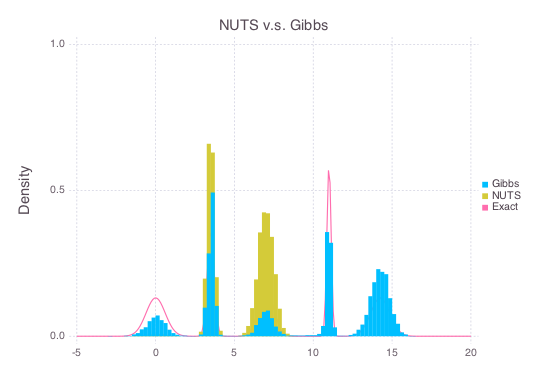

In [6]:
make_plot(x_gibbs, x_nuts)

### 3.3 Sampling from MoG(s) with setting 2

In [7]:
μ = [   0,    1,     2, 3.5, 4.25] + 0.5 * collect(0:4)

println("Running Gibbs")
chain_gibbs = sample(gmm_gen(p, μ, σ), Gibbs(round(Int,N/K), PG(10, 1, :z), HMC(K-1, 0.2, 4, :x); thin=false))
x_gibbs = map(x_arr -> x_arr[1], chain_gibbs[:x]);

println("Running NUTS")
chain_nuts = sample(gmm_gen_marg(p, μ, σ), NUTS(N, 0.65))
x_nuts = map(x_arr -> x_arr[1], chain_nuts[:x]);

Running Gibbs
[Turing]:  Assume - `z` is a parameter
  in @~(::Any, ::Any) at compiler.jl:49
[Turing]:  Assume - `x` is a parameter
  in @~(::Any, ::Any) at compiler.jl:49
[Gibbs] Finished with
  Running time    = 6.598472259000002;


Running NUTS
[Turing] looking for good initial eps...
[Turing.NUTS] found initial ϵ: 2.0
[Turing.WARNING]: Numerical error has been found in gradients.
  in verifygrad(::Array{Float64,1}) at ad.jl:100
[Turing.WARNING]: Numerical error has been found in gradients.
  in verifygrad(::Array{Float64,1}) at ad.jl:100
[Turing.WARNING]: Numerical error has been found in gradients.
  in verifygrad(::Array{Float64,1}) at ad.jl:100
[Turing.WARNING]: Numerical error has been found in gradients.
  in verifygrad(::Array{Float64,1}) at ad.jl:100


[NUTS] Sampling...  9%  ETA: 0:00:19

[Turing]:  Adapted ϵ = 0.0419031098725874, 1000 HMC iterations is used for adaption.
  in step(::Function, ::Turing.Sampler{Turing.NUTS}, ::Turing.VarInfo, ::Bool) at nuts.jl:135


[NUTS] Sampling... 98%  ETA: 0:00:01

### 3.4 Visualization of setting 2

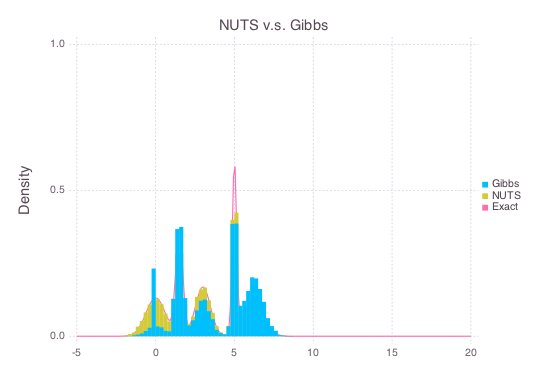

In [8]:
make_plot(x_gibbs, x_nuts)